In [87]:
# Import packages
import numpy as np
import cvxpy as cp
import mosek
import time
import math
from sklearn.model_selection import train_test_split

import phi_divergence as phi
import robust_sampling as rs
import dataio
import util

# Problem specific functions:
def generate_data(random_seed, k, N):
    np.random.seed(random_seed)
    data = np.random.uniform(-1,1,size = (N,k)) # generates N random scenarios    
    return data 

def generate_data_with_nominal(random_seed, k, N):
    data_nominal = np.array([[0] * k])
    np.random.seed(random_seed)
    data = np.random.uniform(-1,1,size = (N-1,k)) # generate N-1 scenarios
    data = np.concatenate((data_nominal,data)) # add nominal case to training data
    return data

def solve_P_SCP(k, S, settings):
    time_limit = settings.get('time_limit')
    x = cp.Variable(k, nonneg = True)
    if len(S) > 0:
        constraints = [(S @ x) - 1 <= 0, cp.sum(x[0:(k-1)]) <= x[k-1]-1, x<=10]
    else:
        constraints = [cp.sum(x[0:(k-1)]) <= x[k-1]-1, x<=10]
    obj = cp.Maximize(cp.sum(x))
    prob = cp.Problem(obj,constraints)
    try:
        prob.solve(solver=cp.MOSEK, mosek_params = {mosek.dparam.optimizer_max_time: time_limit})
    except cp.error.SolverError:
        return (None, None)
    return (x.value, prob.value)

def unc_func(data, x, settings):
    return (np.dot(data,x)) - 1

def compute_prob_add(lhs_constr):
    method = 'deterministic_w_1%'
    if method == 'deterministic':
        if lhs_constr <= 0:
            return 0
        else:
            return 1
    elif method == 'deterministic_w_1%':
        if lhs_constr <= 0:
            return 0.01
        else:
            return 0.99
    elif method == 'sigmoid':
        return util.compute_prob_add_sigmoid(lhs_constr)
    else:
        print('Error: do not recognize method in "compute_prob_add" function')
        return 1
    
def stopping_cond(stop_info, **kwargs):
    if (kwargs.get('elapsed_time',0) >= stop_info.get('max_elapsed_time', 10e12) 
        or kwargs.get('num_solutions',0) >= stop_info.get('max_num_solutions', 10e12)
        or kwargs.get('num_iterations',0) >= stop_info.get('max_num_iterations', 10e12)):
        return True
    else:
        return False

def analytic_eval(x, problem_info):
    k = problem_info['k']
    return get_true_prob(x, k)
    
def get_true_prob(x, k):
    return(1/2+1/(2*x[k-1]))
    
def solve_toyproblem_true_prob(beta, k):
    x = cp.Variable(k, nonneg = True)
    constraints = [(1-2*beta)*x[k-1] + 1 >= 0, cp.sum(x[0:(k-1)]) <= x[k-1]-1, x<=10]
    obj = cp.Maximize(cp.sum(x))
    prob = cp.Problem(obj,constraints)
    prob.solve(solver=cp.MOSEK)
    return(x.value, prob.value)

In [77]:
import matplotlib.pyplot as plt

# Matplotlib settings:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 600 # can be increased for better quality

plt.rcParams.update({
    'font.size': 10,
    'text.usetex': False,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

In [76]:
def plot_1st_iter(num_iter, data, Z_arr, x, obj, p, lb, true_prob, save_plot, plot_type, show_legend,
              N, alpha, beta, data_test=None):
    
    plt.plot(data[:,0],data[:,1],ls='', color='tab:blue', marker=".",markersize=8, label = 'Training data')
    
    if data_test is not None:
        plt.plot(data_test[:,0],data_test[:,1],ls='', color='tab:orange', marker="*",markersize=8, label = 'Test data')
    
    if Z_arr is not None:
        plt.plot(Z_arr[:,0],Z_arr[:,1], color='black', marker='x', linestyle='',
                 markersize=12, label = 'Sampled scenarios')
        
    # Add constraint to plot, given solution x
    constraint_x = np.linspace(-1.05, 1.05, 1000)
    constraint_y = (1 - x[0]*constraint_x) / x[1]
    plt.plot(constraint_x, constraint_y, '--g', label = r'$\xi_1 \bar{x}_1 + \xi_2 \bar{x}_2 \leq 1$' ,alpha=1)

    plt.title(r'Iteration '+str(num_iter)+r': $\mathbf{\bar{x}}_{' + str(num_iter) +'}$ = (' + str(round(x[0],2)) + ', ' 
              + str(round(x[1],2)) + r') $\Rightarrow$ ' + str(round(obj,2)) 
              + r', $\mathrm{\mathbb{P}^{*}}$(feasible) = ' + str(round(true_prob,2)), loc='left')
    
    plt.xlabel(r'$\xi_1$')
    plt.ylabel(r'$\xi_2$')
    
    if show_legend:
        plt.legend(bbox_to_anchor=(1.01, 0.6), loc='upper left')
    
    plt.tight_layout()
    
    if save_plot:
        plot_name = 'output/ToyProblem/Illustrate_wConstraint_iter='+str(num_iter)+'_N=' + str(N) + '_alpha=' + str(alpha) + "_beta="+ str(beta)
        plt.savefig(plot_name + '.' + plot_type)
    
    plt.show()

In [79]:
def plot_train_iter(num_iter, alpha, beta, data_train, Z_arr, x, obj, true_prob, save_plot, plot_type, show_legend):
    N = len(data_train)
    plt.plot(data[:,0],data[:,1],ls='', color='tab:blue', marker=".",markersize=8, label = 'Training data')
        
    if Z_arr is not None:
        plt.plot(Z_arr[:,0],Z_arr[:,1], color='black', marker='x', linestyle='',
                 markersize=12, label = 'Sampled scenarios')
        
    # Add constraint to plot, given solution x
    constraint_x = np.linspace(-1.05, 1.05, 1000)
    constraint_y = (1 - x[0]*constraint_x) / x[1]
    plt.plot(constraint_x, constraint_y, '--g', label = r'$\xi_1 \bar{x}_1 + \xi_2 \bar{x}_2 \leq 1$' ,alpha=1)

    plt.title(r'Iteration '+str(num_iter)+r': $\mathbf{\bar{x}}_{' + str(num_iter) +'}$ = (' + str(round(x[0],2)) + ', ' 
              + str(round(x[1],2)) + r') $\Rightarrow$ ' + str(round(obj,2)) 
              + r', $\mathrm{\mathbb{P}^{*}}$(feasible) = ' + str(round(true_prob,2)), loc='left')
    
    plt.xlabel(r'$\xi_1$')
    plt.ylabel(r'$\xi_2$')
    
    if show_legend:
        plt.legend(bbox_to_anchor=(1.01, 0.6), loc='upper left')
    
    plt.tight_layout()
    
    if save_plot:
        plot_name = 'output/ToyProblem/Illustrate_train_iter='+str(num_iter)+'_N=' + str(N) + '_alpha=' + str(alpha) + "_beta="+ str(beta)
        plt.savefig(plot_name + '.' + plot_type)
    
    plt.show()

In [78]:
def plot_test_iter(num_iter, alpha, beta, data_test, x, p_test, b_test, true_prob, save_plot, plot_type, show_legend):
    N = len(data_test)
    plt.plot(data_test[:,0],data_test[:,1],ls='',color='tab:orange',marker="*",markersize=8, label = 'Test data')
        
    # Add constraint to plot, given solution x
    constraint_x = np.linspace(-1.05, 1.05, 1000)
    constraint_y = (1 - x[0]*constraint_x) / x[1]
    plt.plot(constraint_x, constraint_y, '--g', label = r'$\xi_1 \bar{x}_1 + \xi_2 \bar{x}_2 \leq 1$' ,alpha=1)

    plt.title(r'Iteration '+str(num_iter)+r': $\mathbf{\bar{x}}_{' + str(num_iter) +'}$ = (' + str(round(x[0],2)) + ', ' 
              + str(round(x[1],2)) + r') , $p^{*}$ = ' + str(round(true_prob,2))
              + r', $\hat{p}$ = '+str(round(p_test,2)) + r', $b_{\alpha}$ = '+str(round(b_test,2)) 
              , loc='left')
    
    plt.xlabel(r'$\xi_1$')
    plt.ylabel(r'$\xi_2$')
    
    if show_legend:
        plt.legend(bbox_to_anchor=(1.01, 0.6), loc='upper left')
    
    plt.tight_layout()
    
    if save_plot:
        plot_name = 'output/ToyProblem/Illustrate_test_iter='+str(num_iter)+'_N=' + str(N) + '_alpha=' + str(alpha) + "_beta="+ str(beta)
        plt.savefig(plot_name + '.' + plot_type)
    
    plt.show()

In [94]:
alpha=0.05
beta=0.75
max_num_iterations = 1000

# Set parameter values
k = 2
beta = beta
problem_info = {'k': k,
                'risk_measure': 'probability', # options: 'probability'/'expectation'
                'time_limit': 5*60,
                'desired_prob_guarantee_beta': beta}


# Set our own algorithm parameter values
conf_param_alpha = alpha
N_total = 200
N_train = int(N_total / 2)
N_test = N_total - N_train
bound_settings = {'min_num_obs_per_bin': 5,
                  'num_bins_range': [10,min(20, math.floor(N_test/5))]}


# Set other parameter values
phi_div = phi.mod_chi2_cut
phi_dot = 2
numeric_precision = 1e-6 # To correct for floating-point math operations

# Get generated data
random_seed = 0
data = generate_data_with_nominal(random_seed, k, N_total)
data_train = data[:N_train]
data_test = data[N_train:]

stop_info = {'max_elapsed_time': 10*60, # in seconds (time provided to search algorithm)
             'max_num_solutions': 10000,
             'max_num_iterations': max_num_iterations}

use_tabu = False # Determines whether the tabu list are used in the search

add_strategy = 'random_vio'
remove_strategy = 'random_any'
clean_strategy = None #(100, 'all_inactive') 

# Sets the Problem to be solved at each iteration
solve_P = solve_P_SCP
# solve_P = solve_P_SAA


(runtime, 
 num_iter, 
 solutions, 
 best_sol, 
 pareto_solutions) = rs.gen_and_eval_alg_con(solve_P, unc_func, problem_info,
                                             data_train, data_test, conf_param_alpha, 
                                             bound_settings, phi_div, phi_dot,
                                             stopping_cond, stop_info, compute_prob_add,
                                             add_strategy, remove_strategy, clean_strategy, 
                                             use_tabu, numeric_precision, random_seed, 
                                             None, None, 
                                             analytic_eval,
                                             False, False)

In [95]:
best_sol

{'sol': array([0.26873011, 1.26873011]),
 'obj': 1.5374602215513045,
 'time': 1.0347020626068115,
 'bound_train': -0.10390940082892763,
 'bound_test': -0.07867473217542009,
 'scenario_set': [1, 14, 55]}

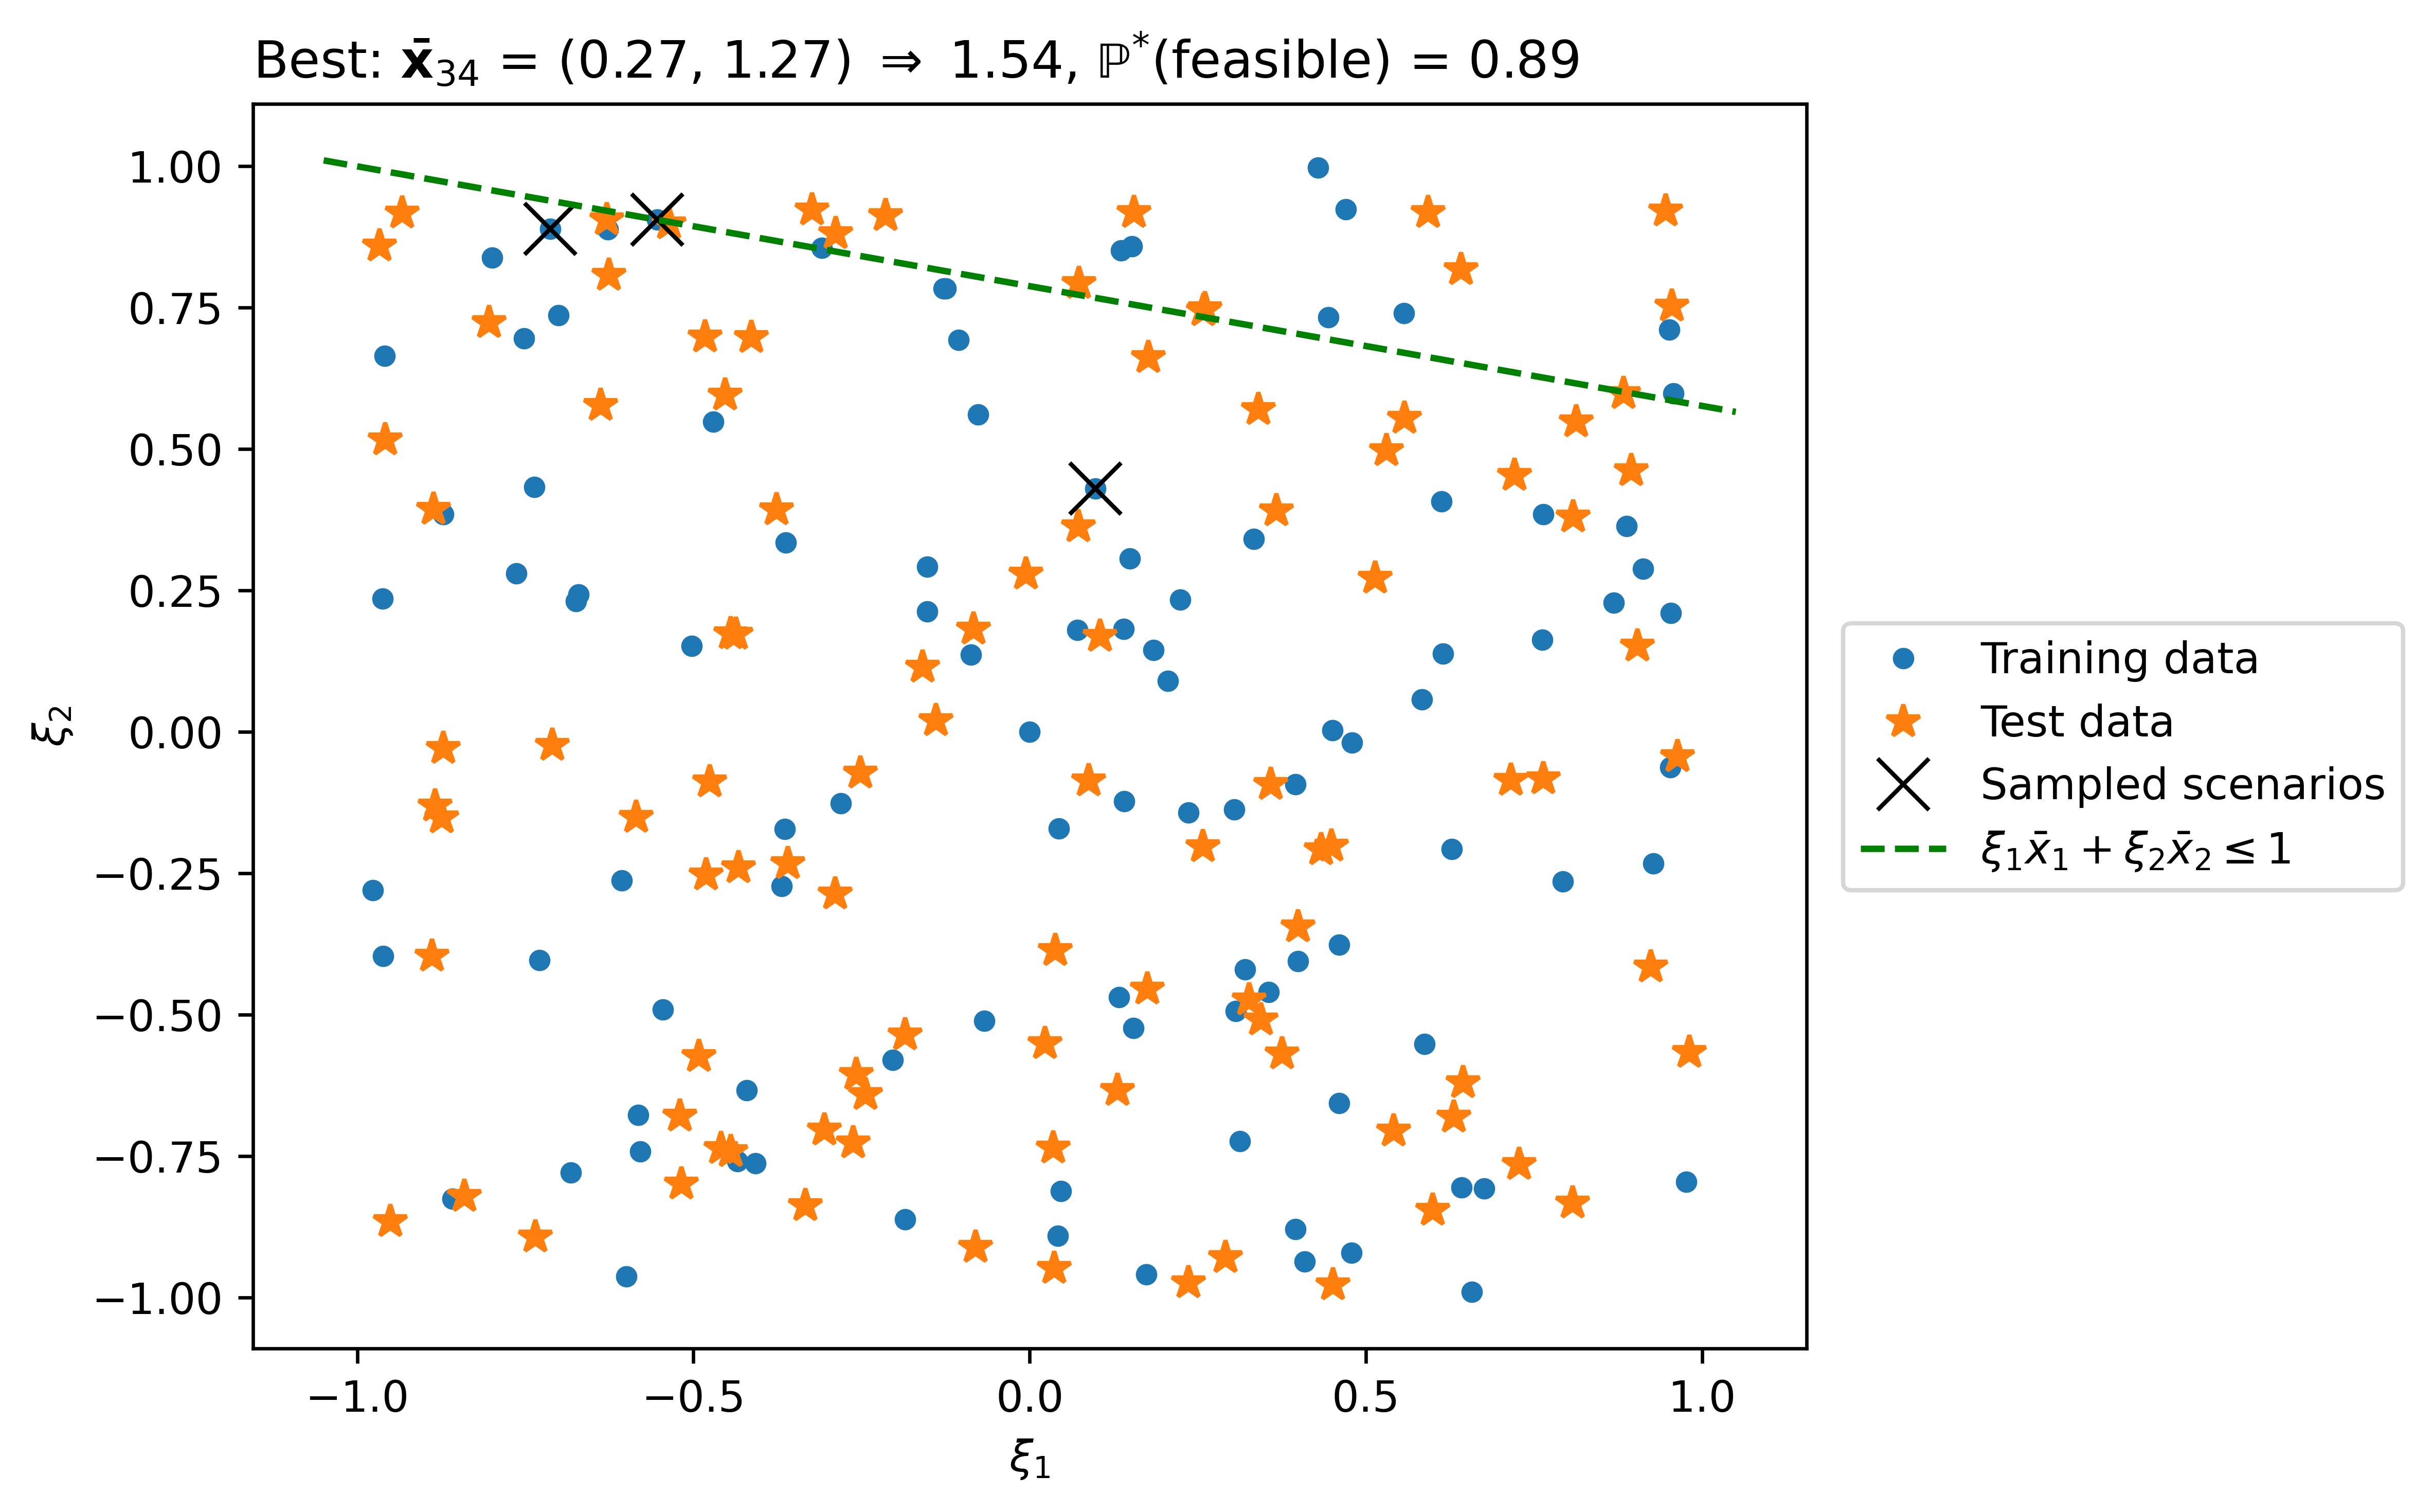

In [125]:
Z_arr = data_train[best_sol['scenario_set']]
x = best_sol['sol']
obj = best_sol['obj']
true_prob = analytic_eval(x, problem_info)
b_train = -1*(best_sol['bound_train']-beta)
b_test = -1*(best_sol['bound_test']-beta)
p_train = 1-sum(unc_func(data_train, x, problem_info)>(0+numeric_precision)) / len(data_train)
p_test = 1-sum(unc_func(data_test, x, problem_info)>(0+numeric_precision)) / len(data_test)


plot_best_iter(34, data_train, Z_arr, x, best_sol['obj'], p_train, b_train, true_prob,
                      True, "png", True, N_train, conf_param_alpha, beta, data_test)

In [123]:
def plot_best_iter(num_iter, data, Z_arr, x, obj, p, lb, true_prob, save_plot, plot_type, show_legend,
              N, alpha, beta, data_test=None):
    
    plt.plot(data[:,0],data[:,1],ls='', color='tab:blue', marker=".",markersize=8, label = 'Training data')
    
    if data_test is not None:
        plt.plot(data_test[:,0],data_test[:,1],ls='', color='tab:orange', marker="*",markersize=8, label = 'Test data')
    
    if Z_arr is not None:
        plt.plot(Z_arr[:,0],Z_arr[:,1], color='black', marker='x', linestyle='',
                 markersize=12, label = 'Sampled scenarios')
        
    # Add constraint to plot, given solution x
    constraint_x = np.linspace(-1.05, 1.05, 1000)
    constraint_y = (1 - x[0]*constraint_x) / x[1]
    plt.plot(constraint_x, constraint_y, '--g', label = r'$\xi_1 \bar{x}_1 + \xi_2 \bar{x}_2 \leq 1$' ,alpha=1)

    plt.title(r'Best: $\mathbf{\bar{x}}_{' + str(num_iter) +'}$ = (' + str(round(x[0],2)) + ', ' 
              + str(round(x[1],2)) + r') $\Rightarrow$ ' + str(round(obj,2)) 
              + r', $\mathrm{\mathbb{P}^{*}}$(feasible) = ' + str(round(true_prob,2)), loc='left')
    
    plt.xlabel(r'$\xi_1$')
    plt.ylabel(r'$\xi_2$')
    
    if show_legend:
        plt.legend(bbox_to_anchor=(1.01, 0.6), loc='upper left')
    
    plt.tight_layout()
    
    if save_plot:
        plot_name = 'output/ToyProblem/Illustrate_wConstraint_iter='+str(num_iter)+'_N=' + str(N) + '_alpha=' + str(alpha) + "_beta="+ str(beta)
        plt.savefig(plot_name + '.' + plot_type)
    
    plt.show()

In [93]:
def solve_toyproblem_true_prob(beta, k):
    x = cp.Variable(k, nonneg = True)
    constraints = [(1-2*beta)*x[k-1] + 1 >= 0, cp.sum(x[0:(k-1)]) <= x[k-1]-1, x<=10]
    obj = cp.Maximize(cp.sum(x))
    prob = cp.Problem(obj,constraints)
    prob.solve(solver=cp.MOSEK)
    return(x.value, prob.value)

solve_toyproblem_true_prob(0.75, 2)

(array([1., 2.]), 3.0)

In [ ]:
for i,sol in enumerate(solutions):
    if i<=max_num_iterations:
        Z_arr = data_train[sol['scenario_set']]
        x = sol['sol']
        obj = sol['obj']
        true_prob = analytic_eval(x, problem_info)
        b_train = -1*(sol['bound_train']-beta)
        b_test = -1*(sol['bound_test']-beta)
        p_train = 1-sum(unc_func(data_train, x, problem_info)>(0+numeric_precision)) / len(data_train)
        p_test = 1-sum(unc_func(data_test, x, problem_info)>(0+numeric_precision)) / len(data_test)
        
        if i == 0:
            plot_1st_iter(i, data_train, Z_arr, x, sol['obj'], p_train, b_train, true_prob,
                      True, "png", True, N_train, conf_param_alpha, beta, data_test)
            
            plot_test_iter(i, alpha, beta, data_test, x, p_test, b_test, true_prob, True, "png", True)
        else:
            plot_test_iter(i, alpha, beta, data_test, x, p_test, b_test, true_prob, True, "png", True)
        
            plot_train_iter(i, alpha, beta, data_train, Z_arr, x, obj, true_prob,
                            True, "png", True)
    else:
        break

In [74]:
for i,sol in enumerate(solutions):
    if i<=max_num_iterations:
        Z_arr = data_train[sol['scenario_set']]
        print(Z_arr)

[[0. 0.]]
[[ 0.          0.        ]
 [ 0.47910159 -0.01908238]]
[[ 0.          0.        ]
 [ 0.09762701  0.43037873]
 [ 0.47910159 -0.01908238]]
[[ 0.          0.        ]
 [ 0.09762701  0.43037873]
 [ 0.95723668  0.59831713]
 [ 0.47910159 -0.01908238]]
[[ 0.          0.        ]
 [ 0.09762701  0.43037873]
 [ 0.95723668  0.59831713]
 [-0.71329343  0.88933783]
 [ 0.47910159 -0.01908238]]


In [121]:
def plot_pareto_curve_2(pareto_solutions, beta, save_plot, name, plot_type, show_legend):
    # first we convert the list of tuples to a numpy array to get data in proper format
    array = np.array([*pareto_solutions])
    sorted_array = array[np.argsort(array[:, 0])]
    x = -1*(sorted_array[:,0]-beta) # contains lb
    y = sorted_array[:,1] # contains obj
        
    plt.plot(x, y, "-o")
    plt.axvline(beta, ls = '--')
    
    plt.xlabel(r"$b_{\alpha}$")
    plt.ylabel("Objective value");
    
    plt.xticks(np.arange(0.5, 1.01, 0.05))
    
    if show_legend:
        plt.legend(bbox_to_anchor=(1.01, 0.6), loc='upper left')
    
    plt.tight_layout()
    
    if save_plot:
        plot_name = 'output/ToyProblem/ParetoCurve_'+name
        plt.savefig(plot_name + '.' + plot_type)
    
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


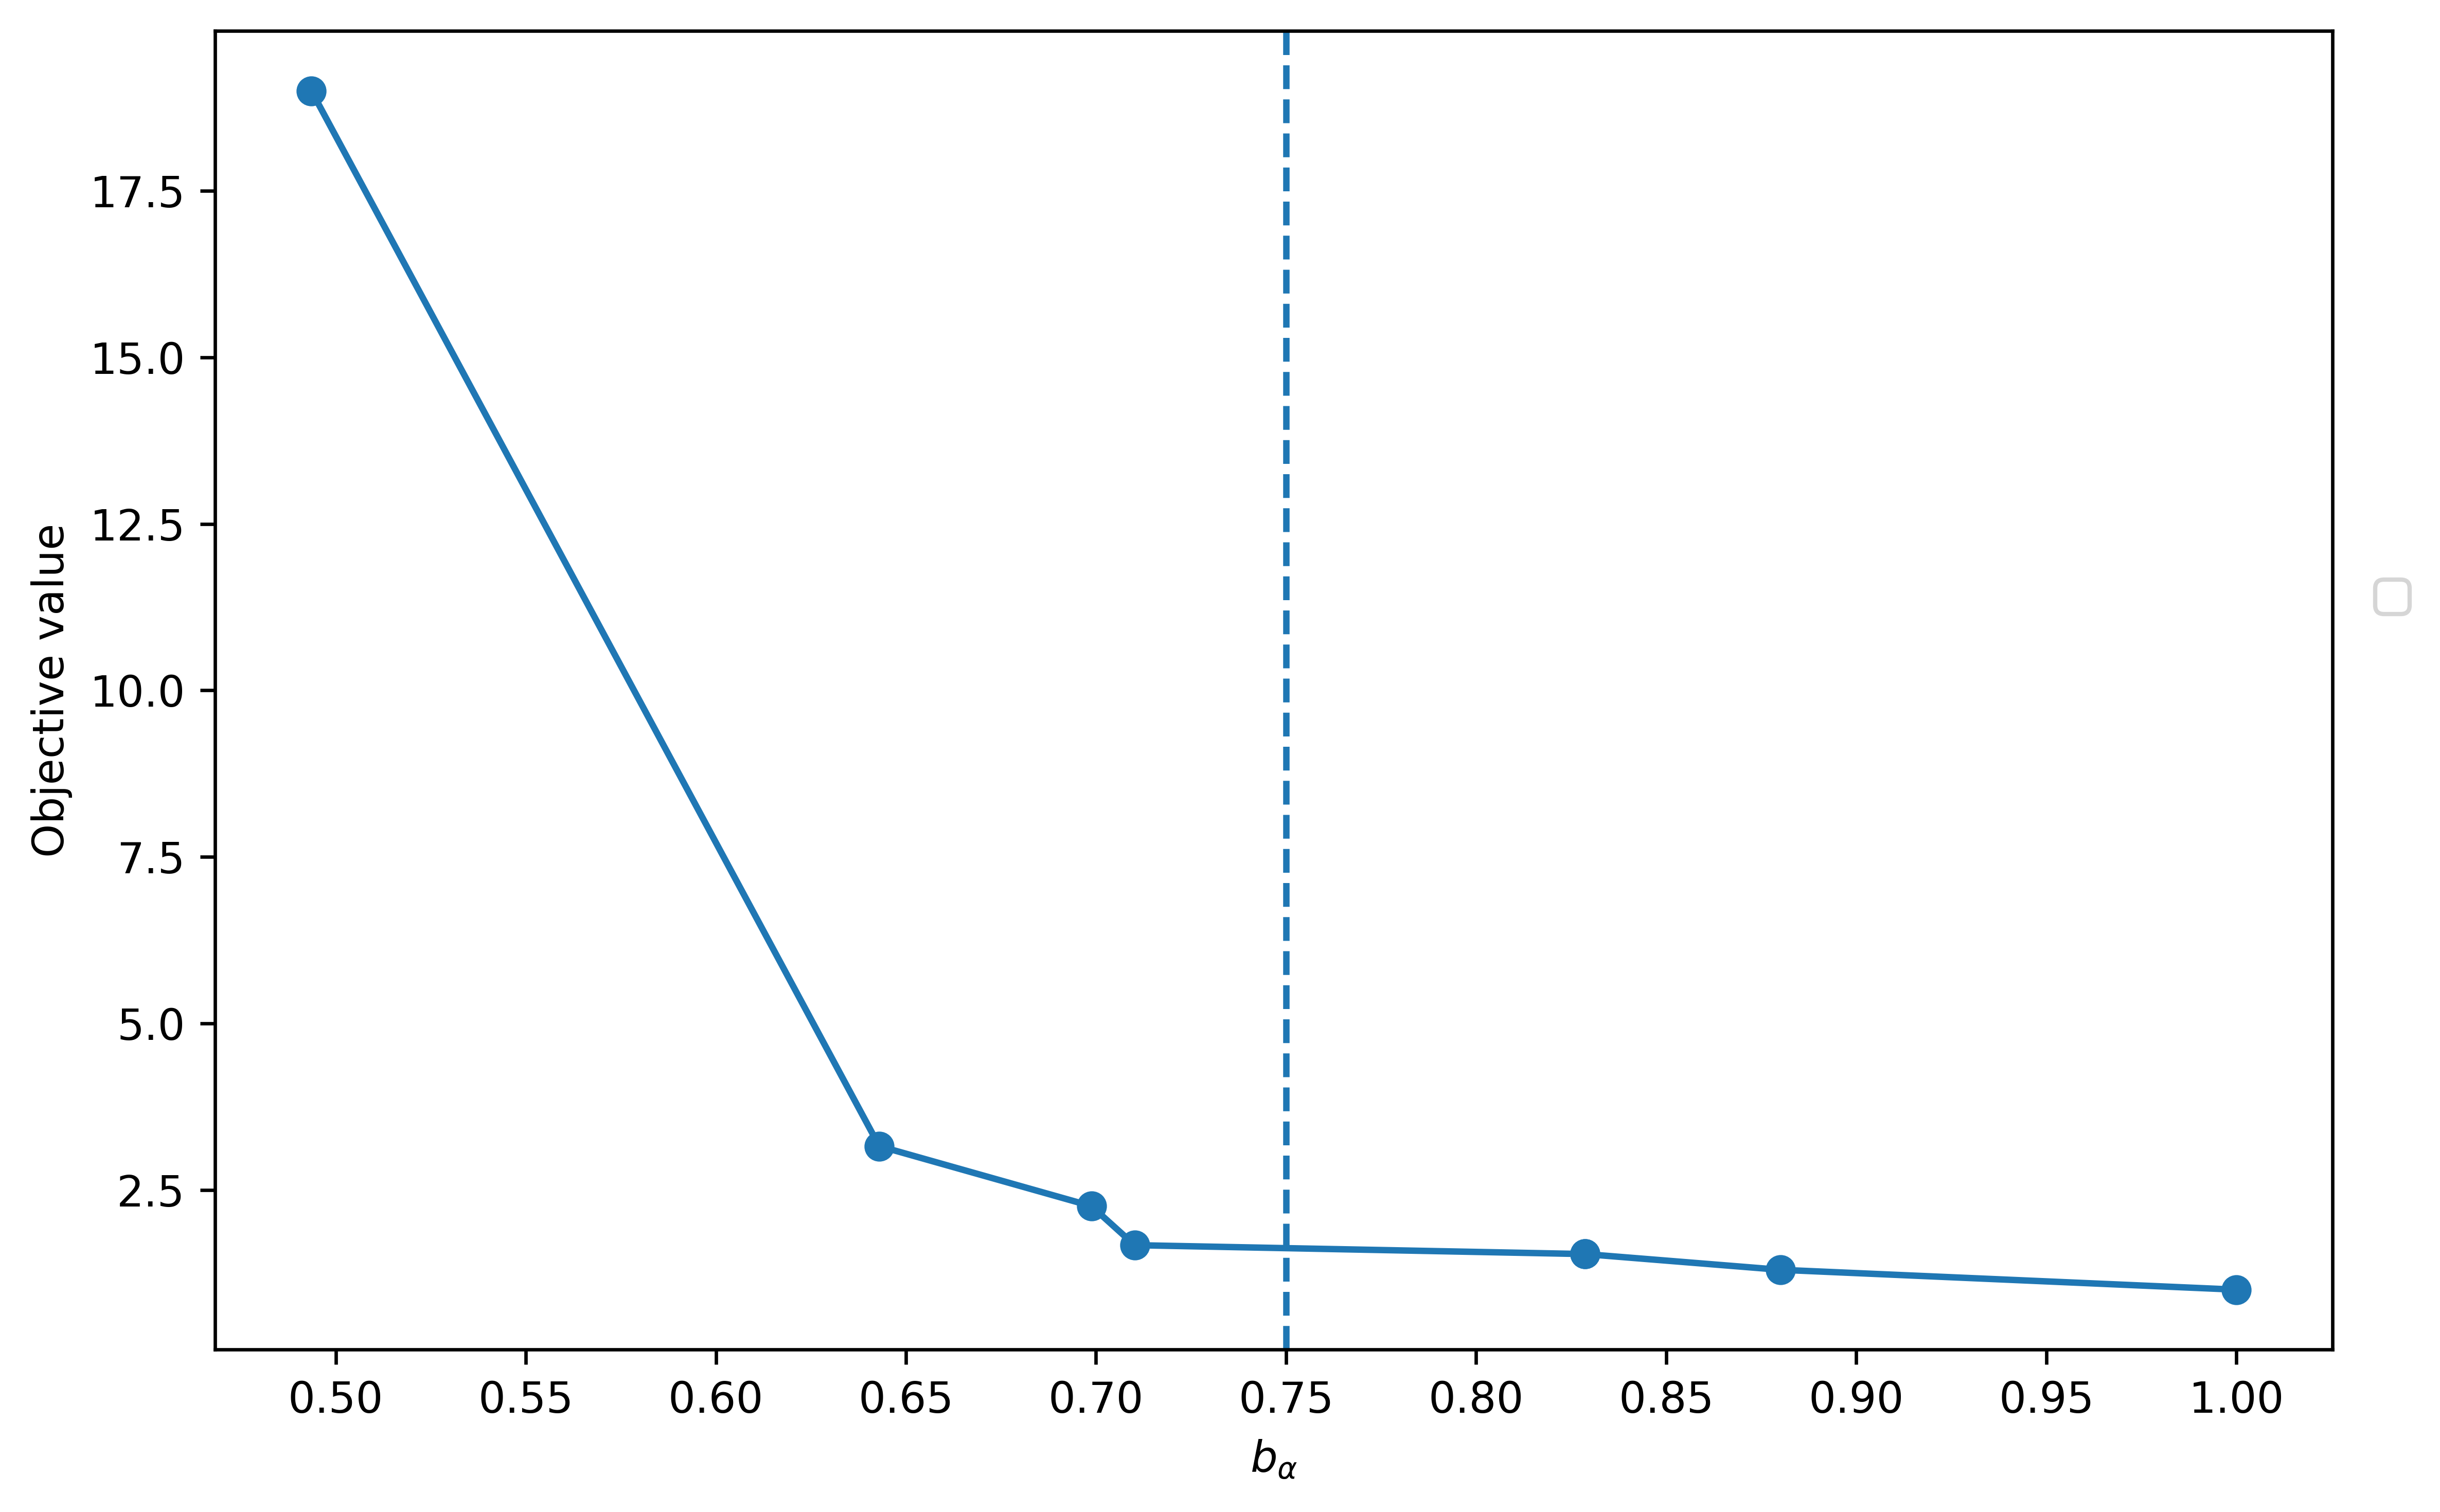

In [122]:
plot_pareto_curve_2(pareto_solutions, 0.75, True, 'demo', "png", True)